# Generating a Ligand Network

In this section we will show the basic functionality of **konnektor** and demonstrate how to construct networks. 

For a comprehensive guide to all network generation algorithms available in **konnektor**, see [konnektor_networks notebook](https://github.com/OpenFreeEnergy/konnektor/blob/main/docs/tutorials/konnektor_example.ipynb).

In [1]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os

if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -U https://github.com/conda-incubator/condacolab/archive/cuda-version-12.tar.gz
    import condacolab

    condacolab.install_mambaforge()
    !wget -q https://raw.githubusercontent.com/OpenFreeEnergy/konnektor/main/examples/environment.yaml
    !mamba env update -q --name=base --file=environment.yaml

    from google.colab import output
    
    output.enable_custom_widget_manager()

## Create demo data, scorer, and mapper

First we will generate a randomized dataset of molecules (``Component``s), alongside an ``AtomMapper`` and ``AtomMappingScorer`` specifically generated for this toy dataset.

The ``AtomMapper`` in our case is an \"edge generator\" allowing us to create all possible edges (``AtomMapping``s) for the set of ``Component``s.

The ``AtomMappingScorer`` simply adds the score (weight) information to the generated edges. This score is treated as an estimate of the difficulty in transforming ``Component_A`` to ``Component_B``, and can be used to try to find the best transformation paths through all the ``AtomMapping``.

In [2]:
from konnektor.utils import toy_data

components, mapper, scorer = toy_data.build_random_dataset(n_compounds=20, rand_seed=42)

## Star Network Layout

The  __Star Network Layout__  is one of the simplest network layouts.
It is efficient and reasonably robust, losing only one ``Component`` should an edge fail.
Its main limitation is the choice of the central ligand, which affects the quality of all the Network's results.

The __Star Network Layout__ can be very easily generated using the `StarNetworkGenerator`.
To create it, we pass the `AtomMapper` and the `AtomMappingScorer` as settings to the generator as they are required for building the possible edges and their associated weights.
This concept will repeat for all the network generators in Konnektor.

**Note:** You can use the `n_processes` flag to parallelize the network generation using multiple CPUs.

In [3]:
from konnektor.network_planners import StarNetworkGenerator

network_planner = StarNetworkGenerator(mappers=mapper, scorer=scorer, n_processes=1)

The network is created by calling an instance of the ``StarNetworkGenerator``, passing in the ``Component``s we want to connect.

To label this network for later use, we add a name to the generated object by setting the ``name`` attribute.

In [4]:
radial_network = network_planner.generate_ligand_network(components)
radial_network.name = "Star Network"
radial_network.name

'Star Network'

**Note:** here the ``StarNetworkGenerator`` automatically selects the central ``Component`` by finding the average best score-performing ``Component``.

You could instead specify the central ``Component`` by setting the ``central_component`` argument when calling the ``StarNetworkGenerator`` instance.

Finally, let's have a look at the network we generated using the `draw_ligand_network` function.
The function returns a matplotlib `Figure`, which can be easily stored as a figure with:

```python
    fig.savefig("./star_network.png")
```

**Note:** The colors indicate the relative connectivity. *Green* `Component`s have an average number of connections, *red* `Component`s have higher than average connectivity.

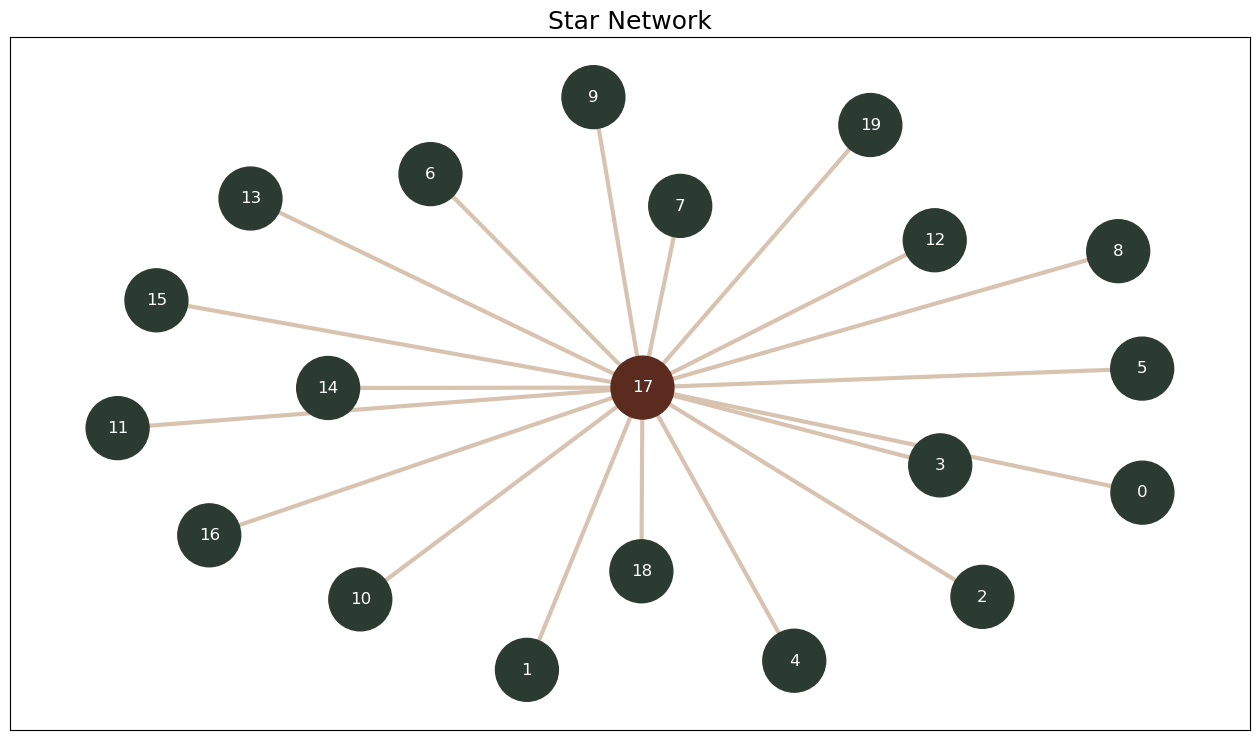

In [5]:
# NBVAL_SKIP
from konnektor.visualization import draw_ligand_network

fig = draw_ligand_network(radial_network, title=radial_network.name)

## Cyclic Network Layout
Next we'll generate a cyclic network using the ``CyclicNetworkGenerator``.
The ``CyclicNetworkGenerator`` works in the same manner as the `StarNetworkGenerator`, but generates a network with a __Cyclic Network Layout__.

This network layout focuses on generating a graph containing a large set of cycles, adding extra redundancies and allowing for cycle closure analysis. Note that this comes at the cost of more edges in the network, meaning more computational time.

In [6]:
from konnektor.network_planners import CyclicNetworkGenerator

network_planner = CyclicNetworkGenerator(mappers=mapper, scorer=scorer)

In [7]:
cyclic_network = network_planner.generate_ligand_network(components)
cyclic_network.name = "Cyclic Network"
cyclic_network.name

'Cyclic Network'

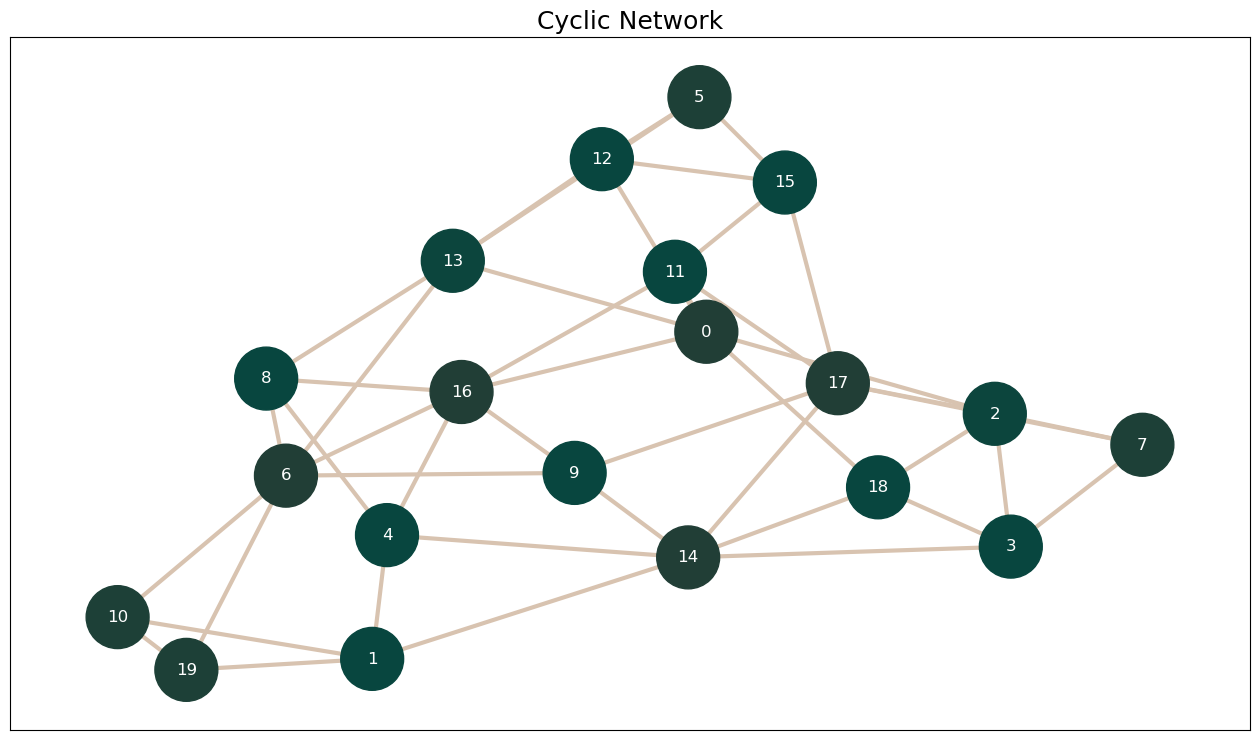

In [8]:
# NBVAL_SKIP
from konnektor.visualization import draw_ligand_network

fig = draw_ligand_network(cyclic_network, title=cyclic_network.name);

## Starry Sky Network Layout
The __Starry Sky Network__ layout is an extension of the __Star Network__ layout, which attempts to circumvent the issue of finding an optimal central ``Component`` by clustering the molecules around multiple central molecules, connecting each central ``Component`` as necessary.

Compared to a standard __Star Network__, this topology is less robust when it comes to edge failure but reduces the risk of high cost edges, and therefore edge failure, when combined with a good scoring function.

This network is generated in three steps:
1. Cluster the input list of ``Components`` based on the class passed to the ``clusterer`` argument. By default this uses an instance of the ``ComponentsDiversityClusterer`` which clusters input Components by their Morgan fingerprints.
2. In each cluster build a sub-network, here with the __Star Network Layout__.
3. Concatenate the star networks with the two best edges between each of the clusters.


In [9]:
from konnektor.network_planners import StarrySkyNetworkGenerator

network_planner = StarrySkyNetworkGenerator(mappers=mapper, scorer=scorer)

In [10]:
starry_sky_network = network_planner.generate_ligand_network(components)
starry_sky_network.name = "Starry Sky Network"
starry_sky_network.name

/Users/atravitz/micromamba/envs/konnektor-tutorials/lib/python3.12/site-packages/sklearn/cluster/_hdbscan/hdbscan.py:722: FutureWarning: The default value of `copy` will change from False to True in 1.10. Explicitly set a value for `copy` to silence this warning.
  warn(
/Users/atravitz/micromamba/envs/konnektor-tutorials/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(
/Users/atravitz/micromamba/envs/konnektor-tutorials/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(
/Users/atravitz/micromamba/envs/konn

'Starry Sky Network'

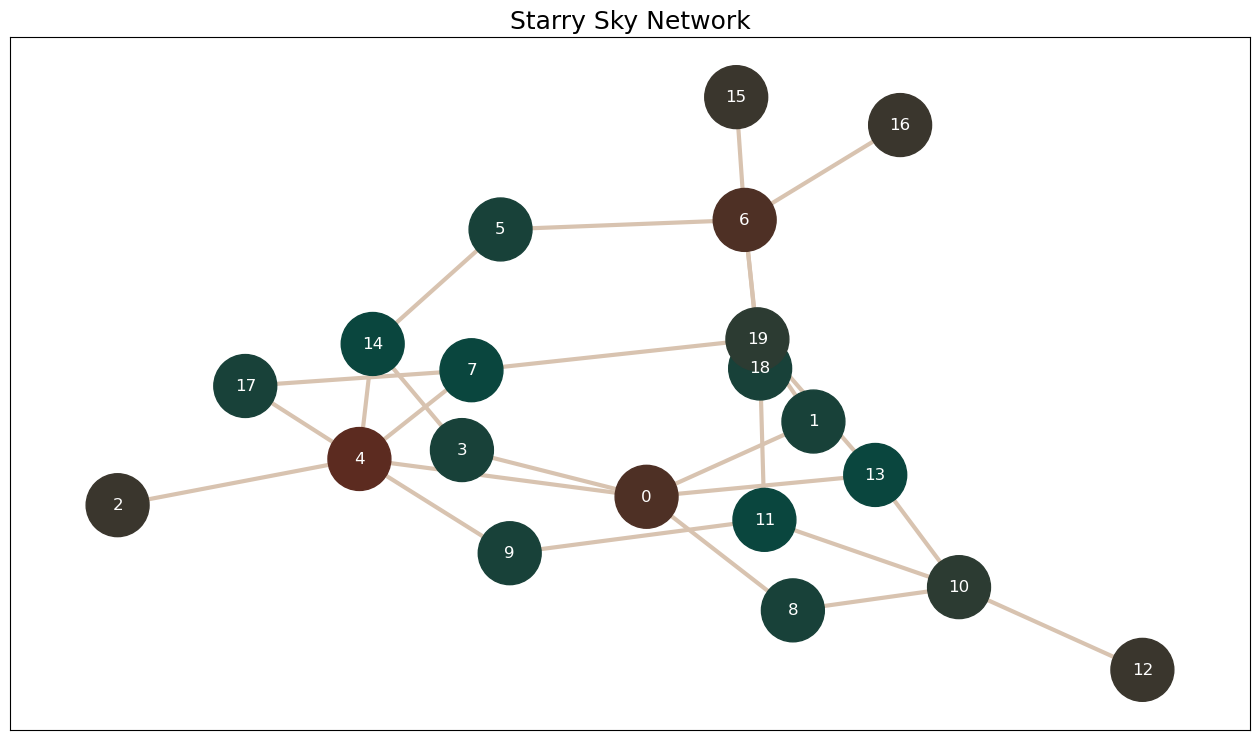

In [11]:
# NBVAL_SKIP
from konnektor.visualization import draw_ligand_network

fig = draw_ligand_network(starry_sky_network, title=starry_sky_network.name);